<a href="https://colab.research.google.com/github/bibekebib/Pytorch-Tutorials-Code-Base/blob/main/Impact_of_Scaling_in_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scaling a dataset is one of the major step of Data Pre-Processing, It is done to reduce the range of data variables. When it comes to image, the minimum - maximum possible value range is always 0-255, that means 255 is the maximum value. So the best way to scale down image array value is to divide it by the maximum value. So the range will always be in between 0-1.

Scaling down the input variables will keep in such a range that, it will be easier for the model to work with, will take less time. 

Here, for the given example we have taken Fashion MNIST dataset described in torch.datasets module. 

A brief about the dataset, it has 10 classes of wear-items, with total of 60000 data points equally distributed as 6000 each class. So, the dataset is balanced, we dont have to look for that. 

First we have defined the program to train, the dataset without scaling down the dataset. More than Code Structure, We are more interested to know the difference scaling of dataset that can come.

I have in short commented out the code structure too. 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw

0
1
2
3
4


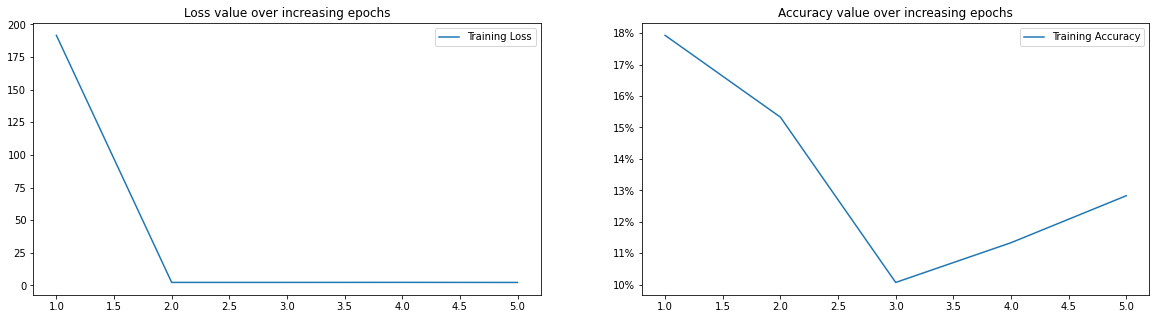

In [ ]:
# Importing all required libraries

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets

# Here we downloaded the datset to data_folder, with train=True indicating, it is for training purpose. 
data_folder = '/data/'

fmnist = datasets.FashionMNIST(data_folder, download=True, train=True) 
tr_images = fmnist.data
tr_targets = fmnist.targets


# Here, we have extended Dataset Class to define dataset the way we wanted, More on this on upcoming tutorials


class FMNISTDataset (Dataset):
  def __init__(self, x, y):
    x = x.float()
    x = x.view(-1, 28*28) #Flattern the input 28*28 image
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  
  def __len__(self):
    return len(self.x)

# Here we simple, loaded dataset defined above, using DataLoader Module in batch_size of 32.

def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  return trn_dl


#   Defining the model

from torch.optim import SGD
def get_model():
  model = nn.Sequential(
      nn.Linear(28*28,1000),
      nn.ReLU(),
      nn.Linear(1000,10)
  ).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr = 1e-2)
  return model, loss_fn, optimizer

#Training the data in defined model

def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  opt.step()
  opt.zero_grad()
  return batch_loss.item()

#For calculating accuracy, here @torch.no_grad() used to define that, we dont calculate gradient while testing.
 
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes ==y
  return is_correct.cpu().numpy().tolist()

#Running Model for training and testing in number of epochs


train_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuricies = [], []
for epoch in range(5):
  print(epoch)
  epoch_losses, epoch_accuricies = [], []
  for ix, batch in enumerate(iter(train_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate(iter(train_dl)):
    x, y  =batch
    is_correct = accuracy(x, y, model)
    epoch_accuricies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuricies)
  losses.append(epoch_loss)
  accuricies.append(epoch_accuracy)

#For Plotting purpose. 
 
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuricies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()])
plt.legend()


Here, in above plot we can see that the loss has reduced to a point where it has saturated but, the accuracy seems to be just around 13%, that's not what we want our model to perform right. So, we tweak just single hyperparameter, scaling down the dataset range. Okay, I agrre, you dont want to call it hyperparameter tuning, we don't call it so. 

As mentioned above, we divide the input by it's maximum possible value, i.e 255.

The changed code will be 

```python
class FMNISTDataset (Dataset):
  def __init__(self, x, y):

    #The changed code starts here
    x = x.float()/255
    #The changed code ends here

    x = x.view(-1, 28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
```

Now, lets Rerun the code and see how much change it makes.

0
1
2
3
4


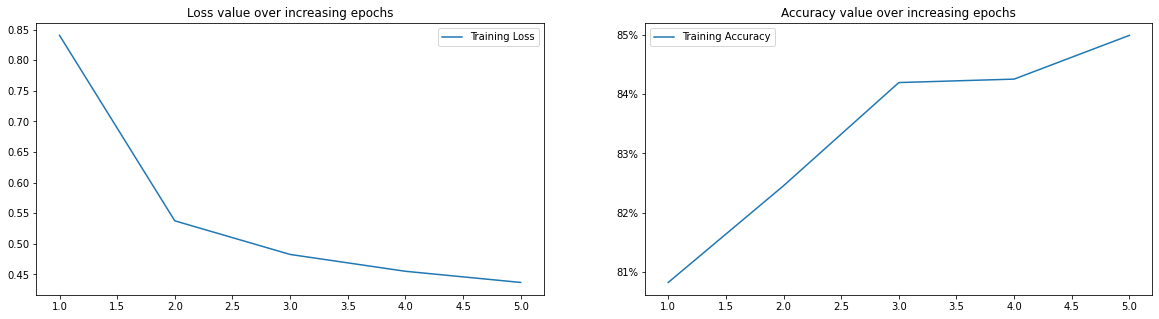

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets


data_folder = '/data/'

fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets


class FMNISTDataset (Dataset):
  def __init__(self, x, y):

    #The changed code starts here
    x = x.float()/255
    #The changed code ends here
    
    x = x.view(-1, 28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  
  def __len__(self):
    return len(self.x)



def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  return trn_dl



from torch.optim import SGD
def get_model():
  model = nn.Sequential(
      nn.Linear(28*28,1000),
      nn.ReLU(),
      nn.Linear(1000,10)
  ).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr = 1e-2)
  return model, loss_fn, optimizer


def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  opt.step()
  opt.zero_grad()
  return batch_loss.item()


@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes ==y
  return is_correct.cpu().numpy().tolist()



train_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuricies = [], []
for epoch in range(5):
  print(epoch)
  epoch_losses, epoch_accuricies = [], []
  for ix, batch in enumerate(iter(train_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate(iter(train_dl)):
    x, y  =batch
    is_correct = accuracy(x, y, model)
    epoch_accuricies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuricies)
  losses.append(epoch_loss)
  accuricies.append(epoch_accuracy)



epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuricies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()])
plt.legend()


Wow, look at the accuracy, its around 85%, from 13% to 85% just by scaling down the input. 

But what could be the reason for such drastic increase in accuracy merely scaling down the input. Lets, see the math behind this.

We know, 

  sigmoid = 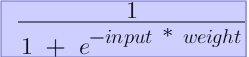
      
So, 

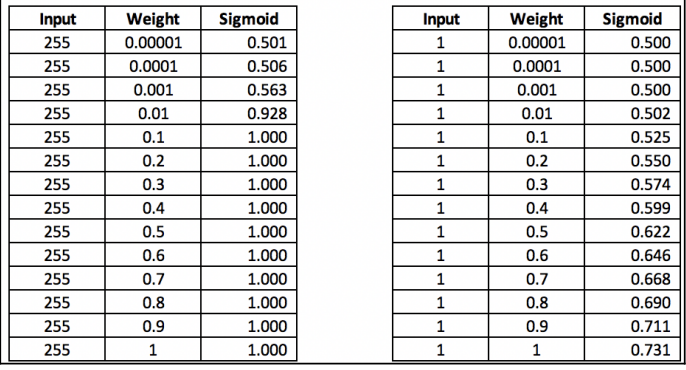


source: Modern Computer Vision with PyTorch

In the left hand side, when the input is 255 and the weight is more than or equal to 0.1, there is no change in the sigmoid output. Similarly the change was also so less when the weight was extremely low. 

The reason is that exponential of the large negative values is very close to 0. But in the right hand side, since the input is 1, we can see change in the sigmoid output. 

Scaling the input dataset so that it contains a much smaller range of
values generally helps in achieving better model accuracy.